In [65]:
# Import required dependencies
import boto3
import sagemaker
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sagemaker import get_execution_role
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig

import os
from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns
import re

In [66]:
# Readind data
bucket_name = 'finance-factoring-ml-dev'
prefix = 'binary-clasification-decision-tree'
s3_model_output_location = 's3://{}/output/{}/model'.format(bucket_name, prefix)

df = pd.read_csv('s3://{}/data/all.csv'.format(bucket_name))
df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,FechaPago
0,1918.0,0,0,1,1953.0,38879.48,33047.56,2351.94,1939.0
1,1634.0,1,1,0,1654.0,6658.40,5659.64,109.45,1638.0
2,1583.0,2,2,1,1551.0,791.12,791.12,29.26,1551.0
3,2282.0,3,3,0,2225.0,33048.00,28090.80,814.88,2226.0
4,2110.0,4,4,0,2170.0,424634.82,360939.60,10615.87,2166.0


# 5. Prepare dataframes for modeling approaches

Build target column "PaidLate"
> * 0: Invoice is paid on time
> * 1: Invoice is paid late

In [67]:
def const_paidLate(df):
    df['PaidLate'] = (df['FechaPago'] > df['FechaVencimiento'])*1
    return df

df = const_paidLate(df)

df.drop("FechaPago", axis=1, inplace=True)

In [68]:
df.head()

,Fecha,RFCCliente,RFCPagador,Moneda,FechaVencimiento,Monto,DepositoInicial,Intereses,PaidLate
0,1918.0,0,0,1,1953.0,38879.48,33047.56,2351.94,0
1,1634.0,1,1,0,1654.0,6658.40,5659.64,109.45,0
2,1583.0,2,2,1,1551.0,791.12,791.12,29.26,0
3,2282.0,3,3,0,2225.0,33048.00,28090.80,814.88,1
4,2110.0,4,4,0,2170.0,424634.82,360939.60,10615.87,0


### Splitting the dataset
We'll then split the dataset into training (70%), validation (20%), and  test (10%) datasets and convert the datasets to the right format the algorithm expects. We'll use training and validation dataset during training and we'll try to maximize the accuracy on the validation dataset/

Once the model has been deployed we'll use the test dataset to evaluate its performance

In [69]:
s3_res = boto3.Session().resource('s3')
csv_buffer_train = StringIO()
csv_buffer_validation = StringIO()
csv_buffer_test = StringIO()

train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=123), 
                                                  [int(0.7 * len(df)), int(0.9 * len(df))])

# Train Data Into Buckets
pd.concat([train_data['PaidLate'], train_data.drop(['PaidLate'], axis=1)], axis=1).to_csv(csv_buffer_train, index=False, header=False)
s3_res.Object(bucket_name, 'data/{}/train.csv'.format(prefix)).put(Body=csv_buffer_train.getvalue())

# Validation Data Into Buckets
pd.concat([validation_data['PaidLate'], validation_data.drop(['PaidLate'], axis=1)], axis=1).to_csv(csv_buffer_validation, index=False, header=False)
s3_res.Object(bucket_name, 'data/{}/validation.csv'.format(prefix)).put(Body=csv_buffer_validation.getvalue())

test_data.drop(['PaidLate'], axis=1).to_csv(csv_buffer_test, index=False, header=False)
s3_res.Object(bucket_name, 'data/{}/test.csv'.format(prefix)).put(Body=csv_buffer_test.getvalue())

{'ResponseMetadata': {'RequestId': '65Z3TX7842M61SW9',
  'HostId': 'tRIoR/7zpKRLr2PdwIjntZ8MKIFMweLHbKPDiGp6OFWACaasxcfFGz8Bxwbo83Wrboswx/dea4o=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'tRIoR/7zpKRLr2PdwIjntZ8MKIFMweLHbKPDiGp6OFWACaasxcfFGz8Bxwbo83Wrboswx/dea4o=',
   'x-amz-request-id': '65Z3TX7842M61SW9',
   'date': 'Mon, 12 Sep 2022 15:14:19 GMT',
   'etag': '"aecf64ffd8b8d91665fc019d4d608ee2"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"aecf64ffd8b8d91665fc019d4d608ee2"'}

In [70]:
# SageMaker needs to know where the training and validation sets are located
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/data/{}/train'.format(bucket_name, prefix), content_type='csv')
s3_input_validation = sagemaker.TrainingInput(s3_data='s3://{}/data/{}/validation'.format(bucket_name, prefix), content_type='csv')

s3_data = {'train': s3_input_train, 'validation': s3_input_validation}

# Training the model

In [71]:
sess = sagemaker.Session()
role = get_execution_role()

# We will use spot for training
use_spot_instances = True
max_run = 3000 # in seconds
max_wait = 3200 if use_spot_instances else None # in seconds

# Use XGBoost 1.2 version 
container = sagemaker.image_uris.retrieve(
    framework='knn',
    region=sess.boto_region_name
)

print (f'Using KNN {container}')

Using KNN 174872318107.dkr.ecr.us-west-2.amazonaws.com/knn:1


In [72]:
save_interval = '1'

# Build model
xgb = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role, 
    instance_count=1, 
    instance_type="ml.m5.2xlarge",
    output_path=s3_model_output_location,
    sagemaker_session=sess,
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait,
    
    debugger_hook_config=DebuggerHookConfig(           # Saving training tensors
        s3_output_path='s3://{}/output/{}/debug'.format(bucket_name, prefix),
        collection_configs=[
            CollectionConfig(
                name='metrics',
                parameters={
                    'save_interval': save_interval
                }
            ),
            CollectionConfig(
                name='feature_importance',
                parameters={
                    'save_interval': save_interval                    
                }
            )
        ]
    ),
    
    rules=[
        Rule.sagemaker(
            rule_configs.class_imbalance(),
            rule_parameters={
                'collection_names': 'metrics'
            }
        )
    ]
)

In [73]:
# Setting hyper parameters
hyperparams = {"feature_dim": 54, "k": 10, "sample_size": 200000, "predictor_type": "classifier"}
xgb.set_hyperparameters(**hyperparams)

In [76]:
xgb.hyperparameters()

{'feature_dim': 54,
 'k': 10,
 'sample_size': 200000,
 'predictor_type': 'classifier'}

In [77]:
xgb.fit(s3_data)

2022-09-12 15:21:00 Starting - Starting the training job...
2022-09-12 15:21:27 Starting - Preparing the instances for trainingClassImbalance: InProgress
ProfilerReport-1662996060: InProgress
.........
2022-09-12 15:22:58 Downloading - Downloading input data...
2022-09-12 15:23:28 Training - Downloading the training image.....................
2022-09-12 15:26:55 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/12/2022 15:26:57 INFO 140537111287616] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'_kvstore': 'dist_async', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv_servers': '1', '_tuning_objective_metric': '', '_faiss_index_nprobe': '5', 'epochs': '1', 'feature_dim': 'auto', 'faiss_index_ivf_nlists': 'auto', 'index_metric': 'L2', 'index_type': 'faiss.Flat', 'mini_batch_size': '5000', '_enable_

UnexpectedStatusException: Error for Training job knn-2022-09-12-15-21-00-145: Failed. Reason: ClientError: No iterator has been registered for ContentType ('csv', '1.0'), exit code: 2

In [ ]:
xgb.latest_training_job.rule_job_summary()

In [ ]:
import smdebug
from smdebug.trials import create_trial

s3_output_path =xgb.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

In [ ]:
# Plot our metric over time

def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for wich you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and  a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine()
    
    tensors = trial.collection(collection_name).tensor_names
    
    for tensor_name in sorted(tensors):
        if re.match(regex, tensor_name):
            steps, data = get_data(trial, tensor_name)
            ax.plot(steps, data, label=tensor_name)
            
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

In [ ]:
plot_collection(trial, 'metrics')

In [81]:
# Plot feature importance

def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types")
    plot_collection(
        trial,
        'feature_importance',
        regex=f"feature_importance/{importance_type}/.*"
    )

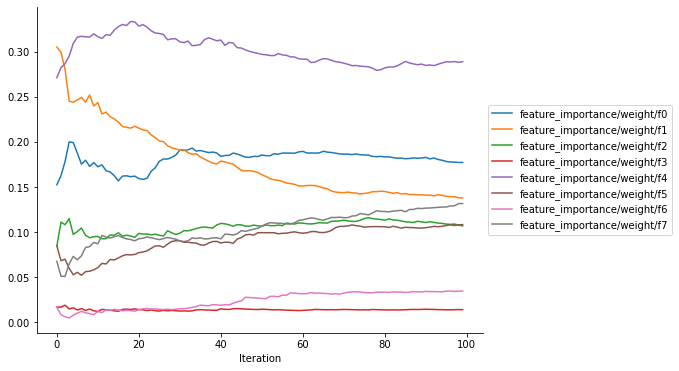

In [79]:
plot_feature_importance(trial)

# Deploying the model

In [91]:
# lets deploy our model to an HTTPS endpoint, and enable data capture.
from sagemaker.model_monitor.data_capture_config import DataCaptureConfig

from time import strftime, gmtime
timestamp = strftime('%d-%H-%M-%S', gmtime())

capture_path = 's3://{}/output/{}/capture/'.format(bucket_name, prefix)

xgb_endpoint = xgb.deploy(
    endpoint_name = 'Finance-factoring-{}-xgboost-{}'.format(prefix, timestamp),
    initial_instance_count=1,                                                        # Infraestructure requirements
    instance_type='ml.m5.xlarge',
    
    data_capture_config = DataCaptureConfig(
        enable_capture = True,                                                       # Capture data
        sampling_percentage = 100,
        # capture_options = ["REQUEST", "RESPONSE"]                                  # Default value
        destination_s3_uri = capture_path                                            # Save data here
    )
)


---------------!

# Predicting with the model

In [241]:
sm = boto3.Session().client(service_name='runtime.sagemaker')

# Lests predict the 10 first samples from the test set
test_samples = pd.read_csv('s3://{}/data/{}/test.csv'.format(bucket_name, prefix), nrows=10, index_col=None)
test_samples = test_samples.values.tolist()

print(test_samples)

single_example = None

for sample in test_samples:
    sample = str(sample)
    
    sample = sample.replace('[', '')
    sample = sample.replace(']', '')
    
    sample = bytes(sample, 'utf-8')
    single_example = sample
    
    response = sm.invoke_endpoint(
        EndpointName=xgb_endpoint.endpoint_name,
        ContentType='text/csv',
        Body=sample
    )

    print(response['Body'].read())




[[401.0, 44.0, 2.0, 0.0, 511.0, 9726.6, 9726.6, 417.31], [1523.0, 73.0, 31.0, 1.0, 1579.0, 1738.38, 1477.62, 80.01], [1223.0, 97.0, 31.0, 0.0, 1357.0, 10962.0, 9317.7, 351.38], [1500.0, 16.0, 270.0, 0.0, 1736.0, 9187.2, 7809.12, 226.53], [1330.0, 3.0, 12.0, 0.0, 1425.0, 51272.0, 43581.2, 4003.43], [1411.0, 0.0, 37.0, 1.0, 1484.0, 1450.0, 1232.5, 52.44], [2218.0, 107.0, 424.0, 1.0, 2247.0, 9893.87, 8409.79, 175.34], [1211.0, 21.0, 39.0, 0.0, 1266.0, 128760.0, 109446.0, 5820.66], [2160.0, 1.0, 1.0, 0.0, 2191.0, 1212.2, 1030.37, 30.89], [1832.0, 84.0, 31.0, 1.0, 2142.0, 9600.0, 8160.0, 862.68]]
b'0.03827109560370445\n'
b'0.6934359073638916\n'
b'0.8603894710540771\n'
b'0.08651121705770493\n'
b'0.6148239970207214\n'
b'0.05498092621564865\n'
b'0.007007214706391096\n'
b'0.27992376685142517\n'
b'0.8779798746109009\n'
b'0.12272383272647858\n'


In [230]:
# Invoke endpoint

client = boto3.client('sagemaker-runtime')

custom_attributes = "c000b4f9-df62-4c85-a0bf-7c525f9104a4"       # An example of a trace ID.
endpoint_name = xgb_endpoint.endpoint_name                       # Your endpoint name.
content_type = 'text/csv'                                        # The MIME type of the input data in the request body.
accept = 'text/csv'                                              # The desired MIME type of the inference in the response.
payload = single_example                                         # Payload for inference.

response = client.invoke_endpoint(
    EndpointName=endpoint_name, 
    CustomAttributes=custom_attributes, 
    ContentType=content_type,
    Accept=accept,
    Body=payload
    )

print(response['Body'].read())

b'0.12272383272647858\n'


For each sample, the binary classifier returns a probability between 0 and 1. Since we decided to maximize the accuracy, the model sets a threshold of o.5: anything lower is treated as a 0, anything higher as a 1.

# Clean up
## Deleting the endpoint
Once that we're donde predicting, we can delete the endpoint (and stop paying for it). We can re-deploy again by running the appropiate cell above.

In [ ]:
sagemaker.Session().delete_endpoint(endpoint_name=xgb_endpoint.endpoint_name)

## Delete S3 ouput folder

In [222]:
bucket = boto3.resource('s3').Bucket(bucket_name)
bucket.objects.filter(Prefix="output/binary-clasification/").delete()

[{'ResponseMetadata': {'RequestId': '9WCX8M14XXQNXVV5',
   'HostId': 'KomIb0V0QHFxnfrIlWVLmBgRZHAqW1F8XpyHfSDnbynGhUra8u/mdow2mQlcj6APEomY1a8hc8w=',
   'HTTPStatusCode': 200,
   'HTTPHeaders': {'x-amz-id-2': 'KomIb0V0QHFxnfrIlWVLmBgRZHAqW1F8XpyHfSDnbynGhUra8u/mdow2mQlcj6APEomY1a8hc8w=',
    'x-amz-request-id': '9WCX8M14XXQNXVV5',
    'date': 'Mon, 15 Aug 2022 14:32:20 GMT',
    'content-type': 'application/xml',
    'transfer-encoding': 'chunked',
    'server': 'AmazonS3',
    'connection': 'close'},
   'RetryAttempts': 0},
  'Deleted': [{'Key': 'output/binary-clasification/debug/sagemaker-xgboost-2022-08-12-21-28-30-212/debug-output/events/000000000022/000000000022_worker_0.tfevents'},
   {'Key': 'output/binary-clasification/debug/sagemaker-xgboost-2022-08-12-21-28-30-212/debug-output/events/000000000097/000000000097_worker_0.tfevents'},
   {'Key': 'output/binary-clasification/debug/sagemaker-xgboost-2022-08-12-21-28-30-212/debug-output/index/000000000/000000000029_worker_0.json'},
  

In [236]:
test_samples = pd.read_csv('s3://{}/data/{}/test.csv'.format(bucket_name, prefix), nrows=10, index_col=None)
# test_samples = test_samples.values.tolist()
# test_samples

{'1649.0': {0: 401.0,
  1: 1523.0,
  2: 1223.0,
  3: 1500.0,
  4: 1330.0,
  5: 1411.0,
  6: 2218.0,
  7: 1211.0,
  8: 2160.0,
  9: 1832.0},
 '73': {0: 44, 1: 73, 2: 97, 3: 16, 4: 3, 5: 0, 6: 107, 7: 21, 8: 1, 9: 84},
 '165': {0: 2, 1: 31, 2: 31, 3: 270, 4: 12, 5: 37, 6: 424, 7: 39, 8: 1, 9: 31},
 '0': {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 0, 8: 0, 9: 1},
 '1722.0': {0: 511.0,
  1: 1579.0,
  2: 1357.0,
  3: 1736.0,
  4: 1425.0,
  5: 1484.0,
  6: 2247.0,
  7: 1266.0,
  8: 2191.0,
  9: 2142.0},
 '21336.37': {0: 9726.6,
  1: 1738.38,
  2: 10962.0,
  3: 9187.2,
  4: 51272.0,
  5: 1450.0,
  6: 9893.87,
  7: 128760.0,
  8: 1212.2,
  9: 9600.0},
 '18135.91': {0: 9726.6,
  1: 1477.62,
  2: 9317.7,
  3: 7809.12,
  4: 43581.2,
  5: 1232.5,
  6: 8409.79,
  7: 109446.0,
  8: 1030.37,
  9: 8160.0},
 '1280.18': {0: 417.31,
  1: 80.01,
  2: 351.38,
  3: 226.53,
  4: 4003.43,
  5: 52.44,
  6: 175.34,
  7: 5820.66,
  8: 30.89,
  9: 862.68}}